IS6400 21/22 Semester B

- Week 8: Time Series (II)
    - AutoRegression models
    
Zhiya Zuo (zhiyazuo@cityu.edu.hk)

Department of Information Systems

City University of Hong Kong

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as SP_STATS

In [2]:
from sklearn import metrics
import statsmodels.api as sm

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [64]:
# if running in Google Colab, please run the following line
# !pip install --upgrade statsmodels

---

# Introduction

So far we have talked about forecasting based on smoothing, in which we start with a naive method and gradually move to more sophisticated ones incorporating trends and seaonalities.
Nonetheless, you may have noticed that there is one characteristics of time series data not discussed before -- _autocorrelation_, i.e., correlation between lagged values.
In this class, we will revisist this concept and then discuss time series modeling with it.

---

# Revisiting Autocorrelation

As mentioned in Week 7, autocorrelation (also known as _seriel correlation_) is used to capture if the time series data is correlated with itself by computing the correlation coefficients between lagged values:

$$ r_k=\frac{\sum_{t=k+1}^{T} (y_t-\bar{y})(y_{t-k}-\bar{y})}{\sum_{t=1}^T(y_t-\bar{y})^2} $$

where $\bar{y}$ is the mean time series value; $T$ is the length of the time series. Intuitively, a small value of $k$ captures the correlation between adjacent time series values whereas a large one captures that between far apart time series values.

What kind of information can we obtain from autocorrelation then? Let's first use an example to refresh our memory:

In [4]:
# data from https://github.com/reisanar/datasets
# amtrak data also available in the `Data/` folder
amtrak = pd.read_csv('../Data/Amtrak.csv', parse_dates=False,
                      index_col='Month', squeeze=True)
amtrak.index = pd.to_datetime(amtrak.index, format='%d/%m/%Y')
amtrak = amtrak.resample('M').mean()

Text(0, 0.5, 'Ridership')

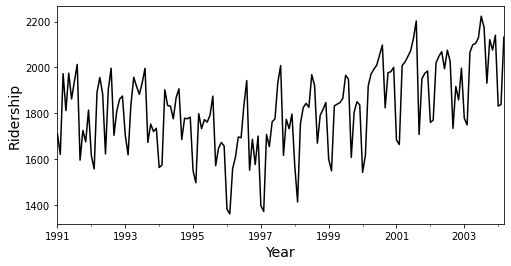

In [5]:
fig, ax = plt.subplots(figsize=[8, 4])
amtrak.plot(ax=ax, color='k')
ax.set_xlabel('Year', size=14)
ax.set_ylabel('Ridership', size=14)

## Autocorrelation vs. Trend/Seasonality

Interestingly, autocorrelation provides yet another source for the detection of trend and seasonality. To see this, let's use the amtrak ridership data as an example

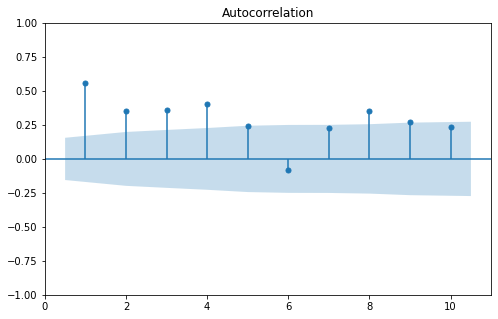

In [6]:
# the shaded region is the 95% CI
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_acf(amtrak, lags=10, ax=ax, zero=False)

In [7]:
autocorr, confint = sm.tsa.stattools.acf(amtrak, nlags=3, bartlett_confint=True, fft=False, alpha=0.05)
print('Lag-1 autocorrelation: %.3f with confint (%.3f, %.3f)'%(autocorr[1], *confint[1]))

Lag-1 autocorrelation: 0.560 with confint (0.404, 0.715)


From this plot, we can see that there is a significant lag-1 autocorrelation meaning that adjacent values are positively related in that large values follow large values in temporal order and smaller values follower smaller ones. 
Similarly, if autocorrelations are negative, then it implies the opposite -- large values may follow small values and vice versa.
Furthermore, there are positive autocorrleation when lag is above 1, such as 2, 3, and 4, and 8. This is important signal that reveals seasonality.

Now let's see if our intrepretation from the autocorrelation diagram (or the correlegram) makes sense by decomposing the time series data. 

In [8]:
stl_decomp = sm.tsa.STL(amtrak).fit()
stl_trend = stl_decomp.trend
stl_seasonal = stl_decomp.seasonal
stl_resid= stl_decomp.resid
stl_lines = {'Data': amtrak,
             'Seasonal': stl_seasonal,
             'Trend': stl_trend,
             'Remainder': stl_resid}

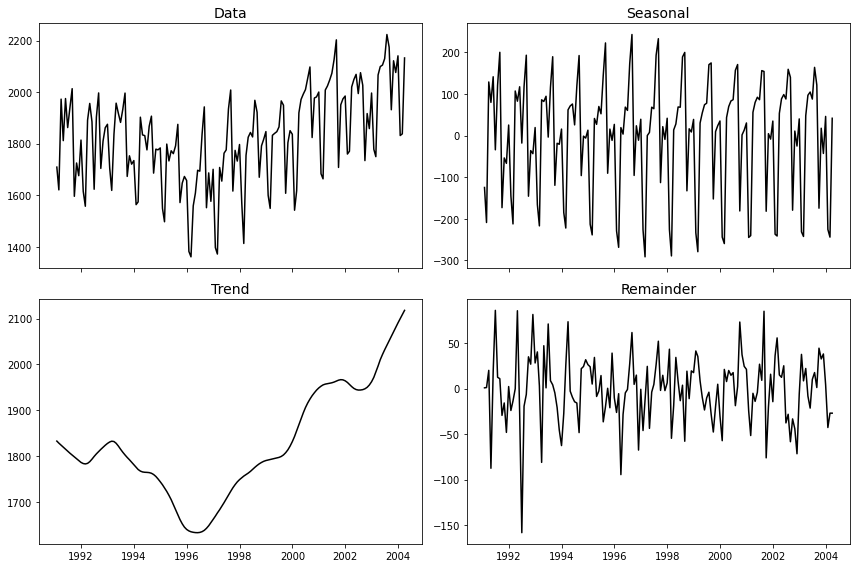

In [9]:
fig, ax_arr = plt.subplots(nrows=2, ncols=2, figsize=[12, 8],
                           sharex=True, sharey=False)
for i, (y_lab, y_val) in enumerate(stl_lines.items()):
    ax = ax_arr.flat[i]
    ax.plot(y_val, color='k')
    ax.set_title(y_lab, size=14)
fig.tight_layout()

The seasonal and trend component shows that there is indeed clear trend over time and periodic cycles within a year.
To re-iterate, autocorrelations at short lags provide signals for trend while those at longer lags for seasonality.

## Partial autocorrelation

Just as correlation, there is the concept of partial autocorrelation that refers to the correlation between time series lags when controlling for lags of smaller orders.
More specifically, the partial autocorrelation for $(y_t, y_{t-k})$ is the amount of correlations between these pair of lagged observations after controlling for the linear correlations resulting from $\{y_j;j\in{t-1,t-2,\ldots,t-(k-1)}\}$, i.e., all lower order autocorrelations.
Note that when $k=1$ (lag 1), then partial autocorrelation is the same as the autocorrelation since there is no lower lag order.

We can compute the partial autocorrelation using `statsmodels`:

In [10]:
pacorr, pacorr_ci = sm.tsa.stattools.pacf(amtrak, nlags=3, alpha=0.05)
for i, pacorr_i in enumerate(pacorr):
    pacorr_ci_i = pacorr_ci[i]
    print('Partial:\nLag %i: %.3f with CI (%.3f, %.3f)'%(i, pacorr_i, *pacorr_ci_i))
    # also print autocorr
    print('Auto:\nLag %i: %.3f with CI (%.3f, %.3f)'%(i, autocorr[i], *confint[i]))
    print('-*-*-*-*'*5)

Partial:
Lag 0: 1.000 with CI (1.000, 1.000)
Auto:
Lag 0: 1.000 with CI (1.000, 1.000)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Partial:
Lag 1: 0.563 with CI (0.408, 0.719)
Auto:
Lag 1: 0.560 with CI (0.404, 0.715)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Partial:
Lag 2: 0.062 with CI (-0.093, 0.218)
Auto:
Lag 2: 0.355 with CI (0.157, 0.554)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
Partial:
Lag 3: 0.208 with CI (0.053, 0.364)
Auto:
Lag 3: 0.360 with CI (0.147, 0.573)
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


We may also visualize the PACF as follows:

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


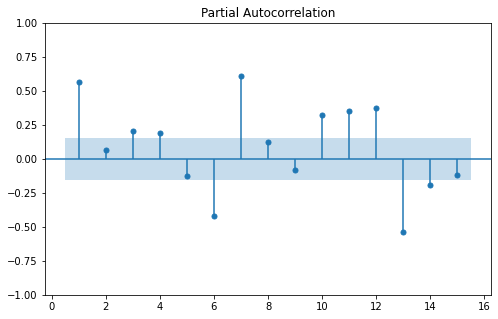

In [11]:
# the shaded region is the 95% CI
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_pacf(amtrak, lags=15, ax=ax, zero=False)

Alright, a followup question you may have now is, why do we need this notion of _partial autocorrelation_? How can we make use of it for time series analysis?
As we shall see later, it is tightly connected with the autoregressive models for time series forecasting.

## White noise

Lastly, it is worth mentioning that there is a special type of time series data called _white noise_.
As its name suggests, you may conjecture that such time series values are random and thus have no patterns whatsoever.
To statistically describe it, we just need to check if a time series has serial correlation or not.
For example, the amtrak data we just used is clearly not white noise.

On the other hand, we can easily generate a series of white noise through random sampling:

In [12]:
white_noise = np.random.normal(0, 1, 1000)

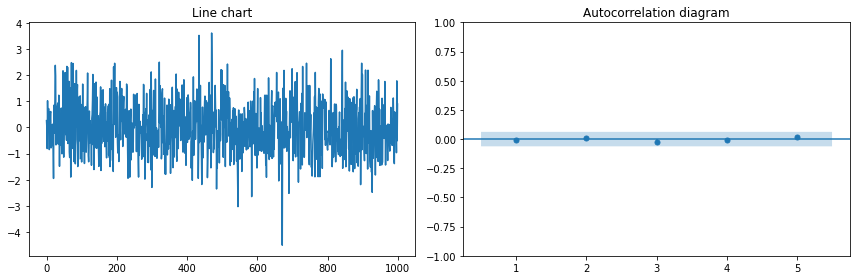

In [13]:
fig, (ax_line, ax_corr) = plt.subplots(figsize=[12, 4], ncols=2)
_ = ax_line.plot(np.arange(white_noise.size), white_noise)
ax_line.set_title('Line chart')
_ = sm.graphics.tsa.plot_acf(white_noise, lags=5, ax=ax_corr, zero=False)
ax_corr.set_title('Autocorrelation diagram')
fig.tight_layout()

---

# AutoRegressive models (AR)

When we are motivating the idea of exponential smoothing, we follow the intuition that the forecast of future time series values can be made by using historical patterns.
Furthermore, the exponential smoothing method assumes that the influence of past time series will be weakened as it moves further back in the history.

Pause for a while now - albeit reasonable at first sight, is this assumption really necessary? 
In other words, how about we try to lift this contraint to increase the model flexibility? 
In this vein, we can in fact write the following forecast model:

$$
\begin{align}
y_{t} &= const + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_py_{t-p)} + \epsilon_t  \\
&= const + \epsilon_t + \sum_{i=1}^{p} \phi_iy_{t-i}
\end{align}
$$

which is similar to the simple exponential smoothing, where $\phi_i = \alpha(1-\alpha)^{i}$ such that there is only one parameter $\alpha$.
The forecast model above is referred to as AR($p$) model, where $p$ denotes the order of the model -- how far away we want to look back.
Now let's try this model!

In [80]:
# train/test split
N_train = int(0.8*amtrak.size)
N_test = amtrak.size - N_train
amtrak_train = amtrak[:N_train]
amtrak_test = amtrak[N_train:]

In [15]:
# set a small p
p = 1
ar_p = sm.tsa.AutoReg(amtrak_train, lags=p, seasonal=False).fit()

In [16]:
result = ar_p.summary()
result.tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,889.4105,140.756,6.319,0.000,613.535,1165.286
Ridership.L1,0.5018,0.079,6.368,0.000,0.347,0.656


In [17]:
ar_p.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  127
Model:                     AutoReg(1)   Log Likelihood                -805.182
Method:               Conditional MLE   S.D. of innovations            144.228
Date:                Tue, 01 Mar 2022   AIC                           1616.364
Time:                        18:57:50   BIC                           1624.873
Sample:                    02-28-1991   HQIC                          1619.821
                         - 07-31-2001                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          889.4105    140.756      6.319      0.000     613.535    1165.286
Ridership.L1     0.5018      0.079      6.368      0.000       0.347       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.9927           +0.0000j            1.9927            0.0000
-----------------------------------------------------------------------------
"""

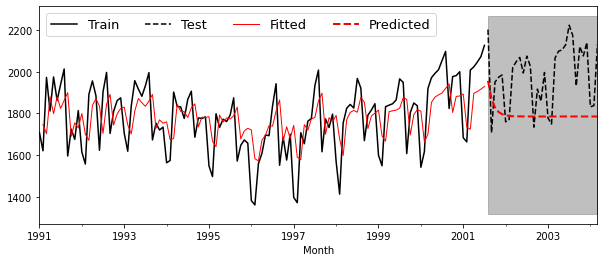

In [18]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_train.plot(color='k', label='Train', ax=ax)
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
ar_p.fittedvalues.plot(ax=ax, color='r',
                       ls='-', lw=1, label='Fitted')
ar_p.forecast(N_test).plot(ax=ax, color='r',
                           ls='--', lw=2, label='Predicted')
ax.fill_betweenx(x1=amtrak_test.index[0], x2=amtrak_test.index[-1],
                 y=ax.get_ylim(), color='gray', alpha=0.5)
ax.legend(prop={'size': 13}, loc=2, ncol=4)
#ax.plot(ar_p.forecast(N_test), color='r', ls='--', lw=2)

Obviously the downward trend is imaginable given the estimated parameter is 0.5018, which means that the one-step ahead forecast is always slightly smaller than the previous value with a constant trend of 889.4105.

As we shall see later, the AR$(p)$ is in effect a special (and simplified) case belonging to a family of autoregressivem models.
Therefore, we may use a more general api [`SARIMAX`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX):

In [19]:
# set a small p
ar_p_ = sm.tsa.SARIMAX(amtrak_train, order=(p, 0, 0), trend='c').fit(disp=False)
ar_p_.params

intercept      889.410503
ar.L1            0.501311
sigma2       20801.725144
dtype: float64

Note that the only difference is the default setup of `trend`: 
- In `AutoReg`, the constant term in the AR model is added by default
- INn `SARIMAX`, we need to manually set `trend='c'` to include the constant term in the AR model

Lastly, we can easily check that there would be almost-perfect correlations since they are essentially the same model:

In [20]:
SP_STATS.pearsonr(ar_p.fittedvalues, ar_p_.fittedvalues[1:])

(0.9999999999999999, 0.0)

## Picking orders

As we mention earlier, the choice of a proper order can be based on the examination of autoregression.
Particularly, because the interpretation of the parameters in the AR models, we may want to take a look at the PACF plot. It seems like 6 or 7 may be a good candidate value for `p`

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


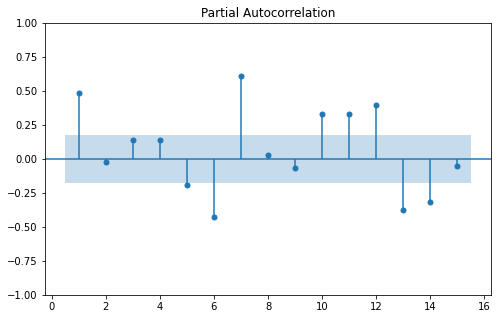

In [21]:
# the shaded region is the 95% CI
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_pacf(amtrak_train, lags=15, ax=ax, zero=False)

In [22]:
p = 7
ar_p_pacf = sm.tsa.SARIMAX(amtrak_train, order=(p, 0, 0), trend='c').fit(disp=False)

In [23]:
# sigma2: https://github.com/statsmodels/statsmodels/issues/e507
ar_summary = ar_p_pacf.summary().tables[1]
ar_summary

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,395.3104,164.905,2.397,0.017,72.102,718.519
ar.L1,0.7228,0.070,10.324,0.000,0.586,0.860
ar.L2,0.0077,0.073,0.105,0.916,-0.136,0.151
ar.L3,-0.0318,0.089,-0.359,0.719,-0.205,0.142
ar.L4,0.1244,0.069,1.794,0.073,-0.012,0.260
ar.L5,0.0457,0.073,0.624,0.533,-0.098,0.189
ar.L6,-0.7274,0.076,-9.533,0.000,-0.877,-0.578
ar.L7,0.6378,0.070,9.111,0.000,0.501,0.775
sigma2,9218.2927,1320.370,6.982,0.000,6630.416,1.18e+04


This result may coincide with our previous conclusion that there is seasonality cycle of 4 given the high autocorrelation at lag 4. Let's compare the forecasts:

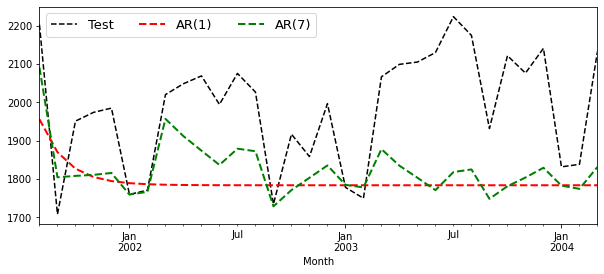

In [24]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
ar_p_.forecast(N_test).plot(ax=ax, color='r',
                           ls='--', lw=2, label='AR(1)')
ar_p_pacf.forecast(N_test).plot(ax=ax, color='g',
                                ls='--', lw=2, label='AR(7)')
ax.legend(prop={'size': 13}, loc=2, ncol=3)

We could compare the forecast errors directly as well by computing the mean squared errors: 

In [25]:
ar_p_mse = metrics.mean_squared_error(y_pred=ar_p_.forecast(N_test).values, y_true=amtrak_test.values)
ar_p_pacf_mse = metrics.mean_squared_error(y_pred=ar_p_pacf.forecast(N_test).values, y_true=amtrak_test.values)
print('AR(1) vs. AR(7): %.3f vs. %.3f'%(ar_p_mse, ar_p_pacf_mse))

AR(1) vs. AR(7): 58144.767 vs. 41458.241


Lastly, to maintain a simpler model, we could try to re-train our model with orders that carry statistically significant coefficients (but need to use the [`AutoReg`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html#statsmodels.tsa.ar_model.AutoReg) api:

In [26]:
p = [1, 6, 7]

In [27]:
ar_p_subset = sm.tsa.AutoReg(amtrak_train, lags=p, trend='c', seasonal=False).fit()
ar_p_subset_mse = metrics.mean_squared_error(y_pred=ar_p_subset.forecast(N_test).values,
                                         y_true=amtrak_test.values)
print('AR(1) vs. AR(7) vs. AR(%s): %.3f vs. %.3f vs. %.3f'%(p, ar_p_mse, ar_p_pacf_mse, ar_p_subset_mse))

AR(1) vs. AR(7) vs. AR([1, 6, 7]): 58144.767 vs. 41458.241 vs. 50071.267


Nonethless, it seems like AR(7) still works the best.

---

# AutoRegressive Moving Average (ARMA)

In this section, we will take a further step to refine the simple AR(4). We start by introducing a model called _moving average_ model (MA).

## Moving average (MA)

First of all, this name is confusing - it is nothing similar with moving average smoothing, i.e., a data processing trick to denoise a certain time series observation value via averaging across adjacent time points.

Rather, this MA model is a forecast method that model future time series value as a linear combination of prior forecast errors, whose intuition is that one could forecast future values based on mistakes made in the past:

$$ y_t = const + \epsilon_t + \sum_{j=1}^{q}\theta_j\epsilon_{t-j} $$

Upon observing this, isn't it coming to you that this is actually not so different from the AR($p$) model? And yes, you are right! Let's take a look at our previous model formulation again with AR(1) as an example:

$$ 
\begin{align}
y_t &= \phi_1y_{t-1} + \epsilon_t + const \\
 &= \phi_1(\phi_1y_{t-2} + \epsilon_{t-1}) + \epsilon_t + const \\
 &= \phi_1^2y_{t-2} + \phi_1\epsilon_{t-1} + \epsilon_t + const \\
 &= \phi_1^2 (\phi_1y_{t-3} + \epsilon_{t-2}) + \phi_1\epsilon_{t-1} + \epsilon_t + const \\
 &= \phi_1^3y_{t-3} + \phi_1^2\epsilon_{t-2} + \phi_1\epsilon_{t-1} + \epsilon_t + const \\
 &= \ldots \\
 &= \epsilon_t + \phi_1\epsilon_{t-1} + \phi_1^2\epsilon_{t-2} + \cdots
\end{align}
$$

Isn't this the MA model with $q\rightarrow \infty$, i.e., the MA($\infty$) model? Now you can even try by yourselves to see whether you can do the opposite, i.e., converting an MA($q$) model to an AR($\infty$) model.

To implement this model, we could utilize the same api call via minor edits over the model setup:

In [95]:
# set a small q
q = 1
ma_q = sm.tsa.SARIMAX(amtrak_train, order=(0, 0, q), trend='c').fit(disp=False)

In [96]:
metrics.mean_squared_error(y_pred=ma_q.forecast(N_test), y_true=amtrak_test.values)

59562.517442431665

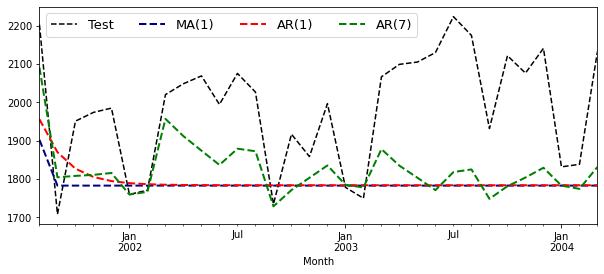

In [97]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
ma_q.forecast(N_test).plot(ax=ax, color='navy',
                           ls='--', lw=2, label='MA(1)')
ar_p_.forecast(N_test).plot(ax=ax, color='r',
                           ls='--', lw=2, label='AR(1)')
ar_p_pacf.forecast(N_test).plot(ax=ax, color='g',
                             ls='--', lw=2, label='AR(7)')
ax.legend(prop={'size': 13}, loc=2, ncol=4)

## Picking orders for the MA model

As it turns out, the model selection process for MA models is very similar to that for AR models, except that we should be looking at the ACF plot rather than the PACF.
If you are interested in the technical details, here is a good video for your reference: [Time Series Talk : Moving Average and ACF](https://youtu.be/_tgB-ri9-8c)

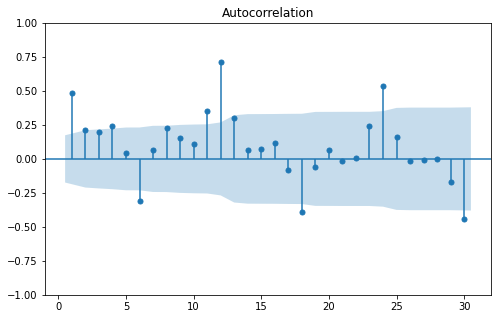

In [117]:
# the shaded region is the 95% CI
fig, ax = plt.subplots(figsize=[8, 5])
_ = sm.graphics.tsa.plot_acf(amtrak_train, lags=30, ax=ax, zero=False)

In [121]:
# set q to 6 based on ACF:
q = 6
ma_acf = sm.tsa.SARIMAX(amtrak_train, order=(0, 0, q), trend='c').fit(disp=False)

In [125]:
metrics.mean_squared_error(y_pred=ma_q.forecast(N_test), y_true=amtrak_test.values)

59562.517442431665

In [126]:
metrics.mean_squared_error(y_pred=ma_acf.forecast(N_test), y_true=amtrak_test.values)

58500.762835135

The bad performance can be partially attributed to the non-stationarity of the data. As we shall see in the ARIMA section, the performance gets better after differencing.

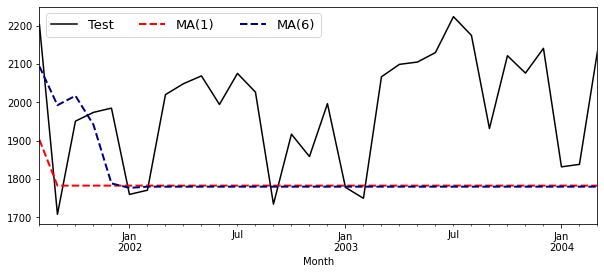

In [123]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, label='Test')
ma_q.forecast(N_test).plot(ax=ax, color='red',
                           ls='--', lw=2, label='MA(1)')
ma_acf.forecast(N_test).plot(ax=ax, color='navy',
                           ls='--', lw=2, label='MA(6)')
ax.legend(prop={'size': 13}, loc=2, ncol=4)

## ARMA

ARMA is obviously a simple aggregation of both AR($p$) and MA($q$) models:

$$
y_t = const + \epsilon_t + \sum_{i=1}^{p} \phi_iy_{t-i} + \sum_{j=1}^{q}\theta_j\epsilon_{t-j}
$$

To run this model, we just need to specify $p$ and $q$ respectively:

In [107]:
p, q = 7, 6
arma = sm.tsa.SARIMAX(amtrak_train, order=(p, 0, q), trend='c').fit(disp=False, maxiter=1e5)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [108]:
metrics.mean_squared_error(y_pred=arma.forecast(N_test), y_true=amtrak_test.values)

43244.45596539244

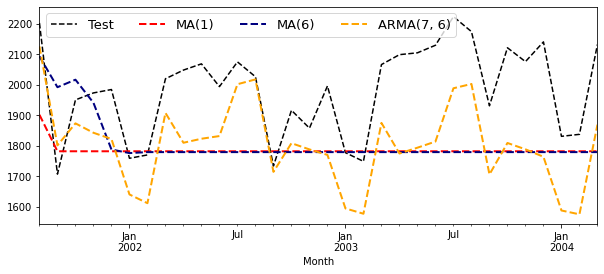

In [110]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
ma_q.forecast(N_test).plot(ax=ax, color='red',
                           ls='--', lw=2, label='MA(1)')
ma_acf.forecast(N_test).plot(ax=ax, color='navy',
                           ls='--', lw=2, label='MA(6)')
arma.forecast(N_test).plot(ax=ax, color='orange',
                           ls='--', lw=2, label='ARMA(7, 6)')
ax.legend(prop={'size': 13}, loc=2, ncol=4)

---

# AR-Integrated-MA (ARIMA)

## Stationarity and differencing

Well, what's the common issue about the forecasts made above? Yes, obviously there's no seasonality or trend being captured! In other words, such models assume that the time series data is _stationary_.
To refresh our memory, let's take a look at how we define this concept in Week 7:
> ... a time series in non-stationary if there are any patterns of trends or seasonalities...

Moreover, we also discussed how we could use _differencing_ to convert a non-stationary time series into a stationary one:

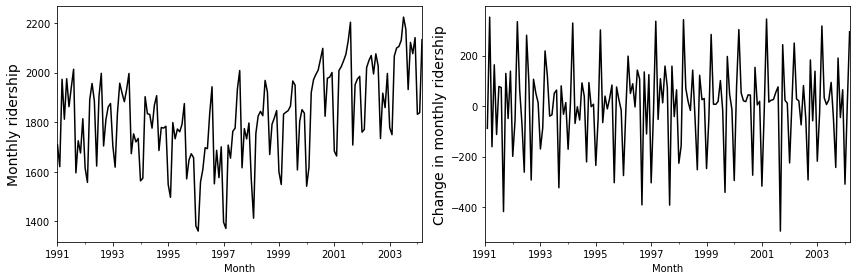

In [38]:
fig, (ax1, ax2) = plt.subplots(figsize=[12, 4], ncols=2)
amtrak.plot(color='k', ax=ax1)
ax1.set_ylabel('Monthly ridership', size=14)
amtrak.diff(1).plot(color='k', ax=ax2)
ax2.set_ylabel('Change in monthly ridership', size=14)
fig.tight_layout()

Visualization implies differencing indeed clears out some non-stationarity out given the white noise-like pattern in the differenced ridership on the right.
Recall that we could further use the KPSS test to supplement the verification:

In [39]:
pval = sm.tsa.stattools.kpss(amtrak, nlags='auto')[1]
pval_diff = sm.tsa.stattools.kpss(amtrak.diff(1).dropna(), nlags='auto')[1]
print('Before differencing: %.3f'%pval)
print('After differencing: %.3f'%pval_diff)

Before differencing: 0.010
After differencing: 0.100


/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


The p-values tell us that before differencing, we are able to reject the hypothesis of the amtrak data being stationary. After differencing this p-value has become 0.1 such that we are unable to reject the stationarity.

Note that when the differenced time series data becomes a white noise series, we may come up with a _random walk_ model since the differenced value $y_t'=y_t-y_{t-1}$ is random.
In other words, we may rewrite this as $y_t=y_{t-1}+\epsilon_t$, where $\epsilon_t$ is just white noise.
This is essentially equivalent to naive forecasts since the one-step ahead predicted value is essentially the current time series value.
Note that it is likely that a one-time differencing may still result in a non-stationary time series. In that case, we may conduct differencing a second time to calculate the difference of difference.

Lastly, it is noteworthy that such kind of lag-1 differencing is essentially a process of _de-trending_.
When certain patterns occur regularly (seasonality such as quarterly or monthly patterns), we may do differencing given a seasonal lag of $m$, a.k.a., _seasonal differencing_ (i.e., _de-seasonality_): $y_t'=y_t-y_{t-m}$.
Following the random walk forecast model, using seasonal differencing may lead to a naive forecast of the one-step ahead prediction using the most recent observation in the same season, i.e., $y_t=y_{t-m}+\epsilon_t$.

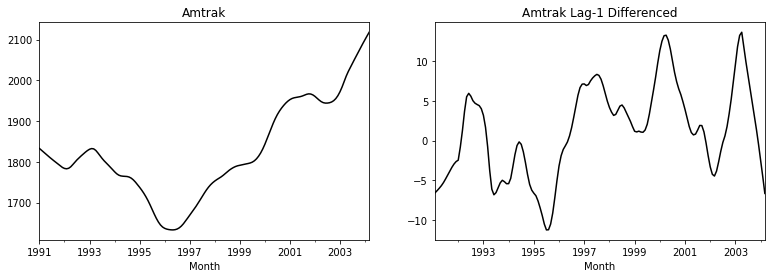

In [137]:
# compare the trend component
trend_nodiff = sm.tsa.STL(amtrak).fit().trend
trend_diff = sm.tsa.STL(amtrak.diff(1).dropna()).fit().trend
fig, (ax_nodiff, ax_diff) = plt.subplots(figsize=[13, 4], ncols=2)
# check out the scale: trend is removed significantly
trend_nodiff.plot(ax=ax_nodiff, color='k')
ax_nodiff.set_title('Amtrak')
trend_diff.plot(ax=ax_diff, color='k')
_ = ax_diff.set_title('Amtrak Lag-1 Differenced')

## ARIMA

The _integrated_ component refers to the reverse of differencing. 
Consequently, ARIMA is in effect the combination of ARMA model with differencing:

$$
y'_t = const + \epsilon_t + \sum_{i=1}^{p} \phi_iy'_{t-i} + \sum_{j=1}^{q}\theta_j\epsilon_{t-j}
$$

where $y'_t$ is the differenced time series value at time $t$. Here, there is no constraint on what kind of differencing (e.g., first, second, seasonal, or more) applied on $y_t$.
Obviously, there are three parameters in an ARIMA($p$,$d$,$q$) model:
- The order of its autoregressive component denoted as $p$
- The order of its moving average component denoted as $q$
- The number of times of differencing denoted as $d$

To connect this back to the simpler models, we know that:
- ARIMA(0,0,0) is equivalent to white noise
- ARIMA(0,1,0) is is equivalent to random walk model
- ARIMA($p$,0,0) is equivalent to AR($p$)
- ARIMA(0,0,$q$) is equivalent to MA($q$)
- ARIMA($p$, 0, $q$) is equivalent to ARMA($p$,$q$)

Now let's try the model with somewhat arbitrary parameter setup:

In [138]:
p, d, q = 2, 0, 1
arima = sm.tsa.SARIMAX(amtrak_train, order=(p, d, q), trend='c').fit(disp=False)

In [139]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  127
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -811.309
Date:                Wed, 02 Mar 2022   AIC                           1632.618
Time:                        01:39:23   BIC                           1646.839
Sample:                    01-31-1991   HQIC                          1638.396
                         - 07-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    736.1844   1.04e+04      0.071      0.943   -1.96e+04    2.11e+04
ar.L1          0.6612     11.544      0.057      0.954     -21.965      23.288
ar.L2         -0.0739      5.734     -0.013      0.990     -11.313      11.165
ma.L1         -0.1700     11.547     -0.015      0.988     -22.802      22.462
sigma2      2.067e+04   3805.129      5.432      0.000    1.32e+04    2.81e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.85
Prob(Q):                              0.85   Prob(JB):                         0.03
Heteroskedasticity (H):               1.13   Skew:                            -0.50
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
metrics.mean_squared_error(y_pred=arima.forecast(N_test), y_true=amtrak_test.values)

58025.21534808002

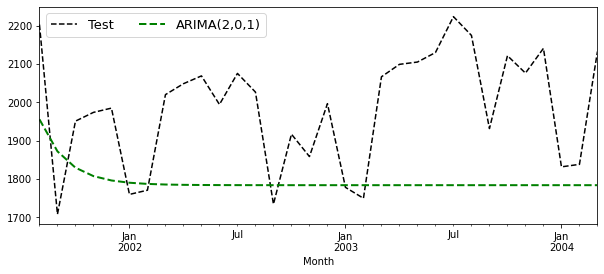

In [141]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
arima.forecast(N_test).plot(ax=ax, color='g',
                           ls='--', lw=2, label='ARIMA(%i,%i,%i)'%(p,d,q))
#arma.forecast(N_test).plot(ax=ax, color='r',
#                           ls='--', lw=2, label='ARMA(4,1)')
ax.legend(prop={'size': 13}, loc=2, ncol=5)

## Choosing parameters for ARIMA

When choosing the parameters for ARIMA, there are two sources of information:
1. Qualitatively, we may try investigate the ACF and PACF plots.
2. Quantitatively, we may try a bunch of candidate values. The best performing one can be then picked.

We now briefly review the ACF/PACF-based approach. These two plots may provide intuitive evidence for different components, AR and MA, respectively. 
- Notably, the regression coefficients in the AR model is equivalent to that estimated in PACF, i.e., the correlation between lagged values _after controlling for prior lags_. Therefore, we may pick the lag with the largest PACF value for $p$.
- Similarly, the MA model is based on the forecast errors. The maximum lag which produces non-zero ACF is usually picked for the MA part, i.e., $q$. A well designed but optional video can be found [here](https://youtu.be/_tgB-ri9-8c) for your reference.
- Lastly, the `I` part is about the level of differencing.

For those who are interested, Prof. Robert Nau from Duke University has a very detailed summary on [the guideline of model identification for ARIMA](https://people.duke.edu/~rnau/arimrule.htm).

Let's take a look at this example:

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


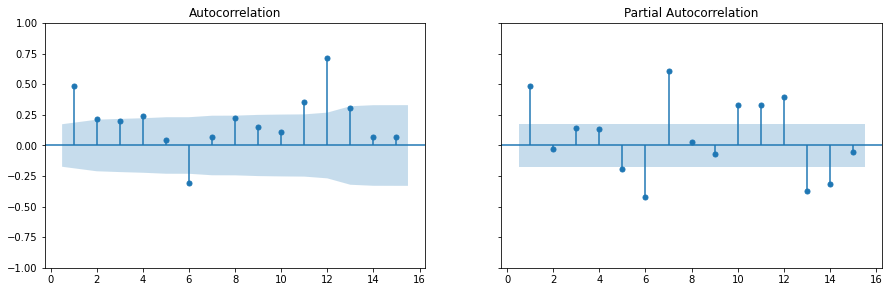

In [44]:
# the shaded region is the 95% CI
fig, (ax_acf, ax_pacf) = plt.subplots(figsize=[15, 4.5], ncols=2, sharey=True)
_ = sm.graphics.tsa.plot_acf(amtrak_train, lags=15, ax=ax_acf, zero=False)
_ = sm.graphics.tsa.plot_pacf(amtrak_train, lags=15, ax=ax_pacf, zero=False)

In this example, we might try $q=6$ and $p=6$ or $p=7$. Nonetheless, this may be a bit larger than we usually use. 


Lastly, it is noteworthy that there is automated approach via some packages for selecting the best performing parameters. 
In `statsmodels`, there is [`statsmodels.tsa.x13.x13_arima_select_order`](https://www.statsmodels.org/devel/generated/statsmodels.tsa.x13.x13_arima_select_order.html#statsmodels.tsa.x13.x13_arima_select_order). However, this involes the installation of [`x13as`](https://www.census.gov/data/software/x13as.X-13ARIMA-SEATS.html)

In [45]:
p, d, q = 7, 1, 6
arima_mychoice = sm.tsa.SARIMAX(amtrak_train, order=(p, d, q), trend='c').fit(disp=False, maxiter=5000)

For simplicity, we try another randomly picked value:

In [46]:
p, d, q = 2, 0, 4
arima_rand = sm.tsa.SARIMAX(amtrak_train, order=(p, d, q), trend='c').fit(disp=False, maxiter=5000)

Check it out: seems like our choice seems pretty good!

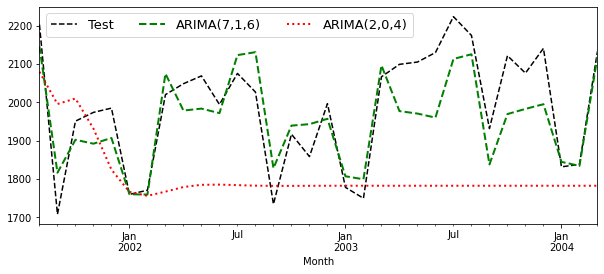

In [47]:
fig, ax = plt.subplots(figsize=[10, 4])
amtrak_test.plot(color='k', ax=ax, linestyle='dashed', label='Test')
arima_mychoice.forecast(N_test).plot(ax=ax, color='g',
                                     ls='--', lw=2, label='ARIMA(%i,%i,%i)'%(7, 1, 6))
arima_rand.forecast(N_test).plot(ax=ax, color='r',
                                 ls='dotted', lw=2, label='ARIMA(%i,%i,%i)'%(2, 0, 4))
ax.legend(prop={'size': 13}, loc=2, ncol=5)

In [48]:
metrics.mean_squared_error(y_pred=arima_mychoice.forecast(N_test), y_true=amtrak_test.values)

6870.606028391945

In [49]:
metrics.mean_squared_error(y_pred=arima_rand.forecast(N_test), y_true=amtrak_test.values)

57586.392584245725

---

# Advanced topics (optional)

## ARIMA with Seasonality

A further step to enrich the ARIMA model is the incoporation of seasonality. 
Obviously, it is inevitable that we are going to need more parameters as a cost for the improved flexibility.
Particularly, seasonality is introduced as an additional set of parameters, namely $(P,D,Q)_m$, where (i) $m$ is still the seasonal window (for monthly observation $m=12$, for instance); (ii) $P$, $D$, $Q$ are similar to their lower case counterparts but only for the seasonal components.
In other words, ARIMA can be generalized into ARIMA($p$,$d$,$q$)($P$,$D$,$Q$)$_m$ such that when $P=D=Q=0$, it is equivalent to the previous model which does not consider seasonal time series data.
There is nothing too different of this extended ARIMA from the one above. The only consideration is whether seasonality is appropriate given the context.
For example, when $D=1$, we are doing differencing with lag-$m$, i.e,. seasonal differencing.

At this stage, we are almost done with the autoregressive models.
However, one confusion one may have is, upon seeing such a complex model with 6 hyperparameters, that how we can pick proper setups?
There are two methods in general:
- Manual selection via visual inspection on autocorrelation diagrams.
- Automatic selection via grid search (i.e., quantitative comparison regarding out-of-sample forecast performance)

We have covered similar ideas in both Weeks 6 and 7 so we now turn to the manual method.
To begin with, let's look at the time series data again:

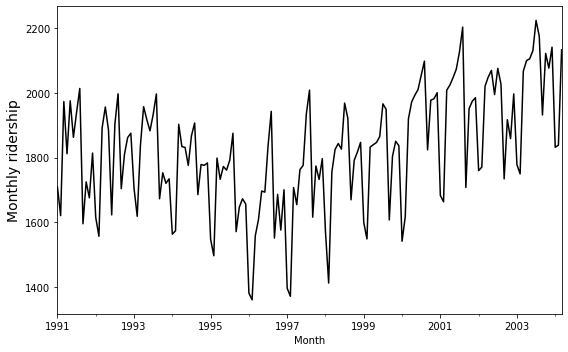

In [50]:
fig, ax = plt.subplots(figsize=[8,5])
amtrak.plot(color='k', ax=ax)
ax.set_ylabel('Monthly ridership', size=14)
fig.tight_layout()

Again, this is clearly non-stationary with a seasonal component (see that autocorrelation values are pretty similar every 12 months).

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


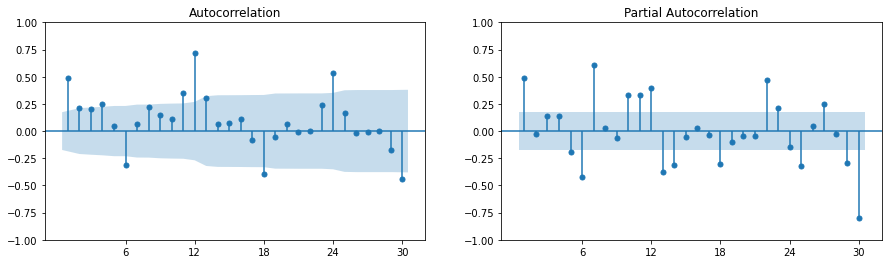

In [51]:
fig, (ax_acf, ax_pacf) = plt.subplots(figsize=[15, 4], ncols=2, sharex=True)
ax_acf.set_xticks(np.arange(6, 31, 6))
sm.graphics.tsa.plot_acf(amtrak_train, lags=30, ax=ax_acf, zero=False)
_ = sm.graphics.tsa.plot_pacf(amtrak_train, lags=30, ax=ax_pacf, zero=False)

A qualitative choice of the seasonal parameters can also be done via the approach we did for the non-seasonal ARIMA but we will only focus on the seasonal lags. Now let's check the autocorrelation of the differenced series regarind the seasonality (of 12):

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


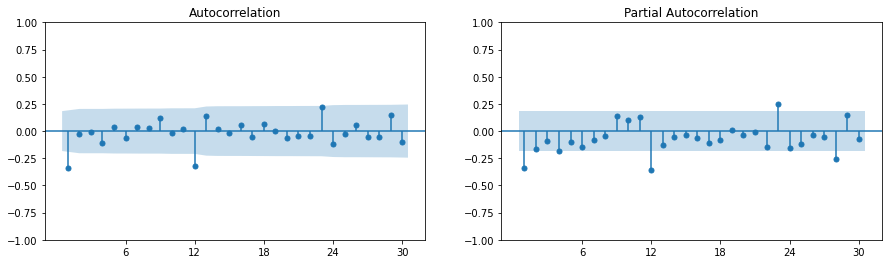

In [52]:
# also a simple differencing (lag-1 differencing)
amtrak_train_diff = sm.tsa.statespace.tools.diff(amtrak_train, k_diff=1,
                                                 k_seasonal_diff=1, seasonal_periods=12)
fig, (ax_acf, ax_pacf) = plt.subplots(figsize=[15, 4], ncols=2, sharex=True)
ax_acf.set_xticks(np.arange(6, 31, 6))
sm.graphics.tsa.plot_acf(amtrak_train_diff, lags=30, ax=ax_acf, zero=False)
_ = sm.graphics.tsa.plot_pacf(amtrak_train_diff, lags=30, ax=ax_pacf, zero=False)

There may be some level of [over-differencing](https://people.duke.edu/~rnau/411arim2.htm). Let's do the seasonal differncing only:
> If the lag-1 autocorrelation is zero or even negative, then the series does not need further differencing.

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


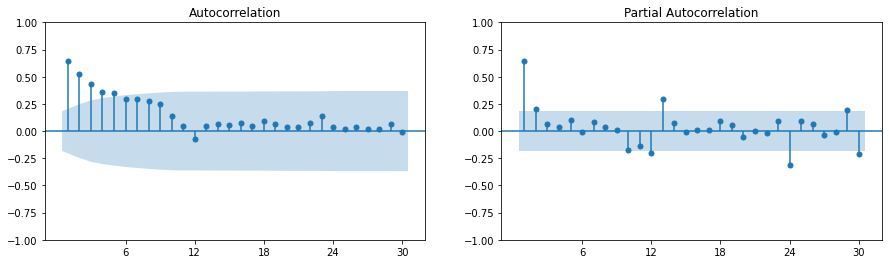

In [53]:
# skip simple differencing (no lag-1 differencing)
amtrak_train_diff = sm.tsa.statespace.tools.diff(amtrak_train, k_diff=0,
                                                 k_seasonal_diff=1, seasonal_periods=12)
fig, (ax_acf, ax_pacf) = plt.subplots(figsize=[15, 4], ncols=2, sharex=True)
ax_acf.set_xticks(np.arange(6, 31, 6))
sm.graphics.tsa.plot_acf(amtrak_train_diff, lags=30, ax=ax_acf, zero=False)
_ = sm.graphics.tsa.plot_pacf(amtrak_train_diff, lags=30, ax=ax_pacf, zero=False)

We pick the non-seasonal components following our qualitative inspection on the correlation diagram. Meanwhile, we do not see much seasonality after differencing in the ACF plot ($Q=0$) and some periodic pattern in the PACF ($P=1$)

In [54]:
p, d, q = 2, 0, 4
P, D, Q = 1, 1, 0
arima_seasonal = sm.tsa.SARIMAX(amtrak_train, order=(p, d, q),
                                seasonal_order=(P, D, Q, 12),
                                trend='c').fit(disp=False, maxiter=5000)

In [55]:
arima_seasonal_mse = metrics.mean_squared_error(y_pred=arima_seasonal.forecast(N_test), y_true=amtrak_test.values)
arima_nonseasonal_mse = metrics.mean_squared_error(y_pred=arima_mychoice.forecast(N_test), y_true=amtrak_test.values)

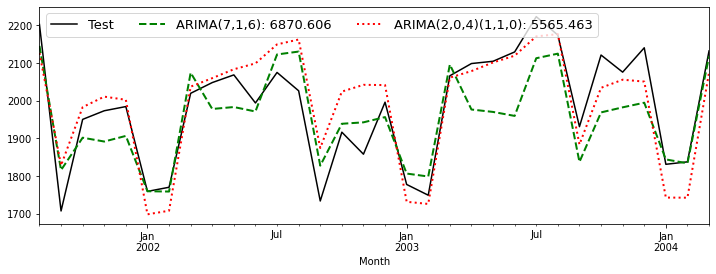

In [56]:
fig, ax = plt.subplots(figsize=[12, 4])
amtrak_test.plot(color='k', ax=ax, label='Test')
lab = 'ARIMA(%i,%i,%i): %.3f'%(7, 1, 6, arima_nonseasonal_mse)
arima_mychoice.forecast(N_test).plot(ax=ax, color='g',
                                     ls='--', lw=2, label=lab)
lab = 'ARIMA(%i,%i,%i)(%i,%i,%i): %.3f'%(p, d, q, P, D, Q, arima_seasonal_mse)
arima_seasonal.forecast(N_test).plot(ax=ax, color='r',
                                     ls='dotted', lw=2, label=lab)
_ = ax.legend(prop={'size': 13}, loc=2, ncol=3)

## Vector AutoRegression

In some occastions, we may want to analyze multiple target values which affect each other simultaneously.
This is where vector autoregression (VAR) comes into play.
As its name suggests, VAR is essentially a regression framework where all variables are _endogenous_ that generalizes from the univariate autoregression model.

Suppose we have two endogenous variables $y$ and $z$, we may write down a VAR model with lag-1 as below:

$$
\begin{align}
y_{t} &= const_1 + \phi_{11} y_{t-1} + \phi_{12} z_{t-1} + \epsilon_{1t}  \\
z_{t} &= const_1 + \phi_{21} y_{t-1} + \phi_{21} z_{t-1} + \epsilon_{2t}  \\
\end{align}
$$

The variables used in these equations follow a similar meaning as before. 

We use an example to show the practical application. The data (collected from [link](https://rdrr.io/rforge/Ecdat/man/Orange.html)) is about orange juice price prediction with the following columns:
- `PPIOJ`: producer price index for finished goods
- `PWFSA`: producer price for frozen orange juice
- `FDD`: freezing degree days (from daily minimum temperature recorded at Orlando area airports)

In [57]:
oj_data = pd.read_csv('../Data/JuicePriceData.csv', index_col='Month')
oj_data.index = pd.to_datetime(oj_data.index, format='%Y-%m')
oj_data.head(2)

,PPIOJ,PWFSA,FDD
Month,,,
1948-01-01,43.3,28.1,0
1948-02-01,39.0,27.9,6


It is always a good habit to visualize the data to know the data better.

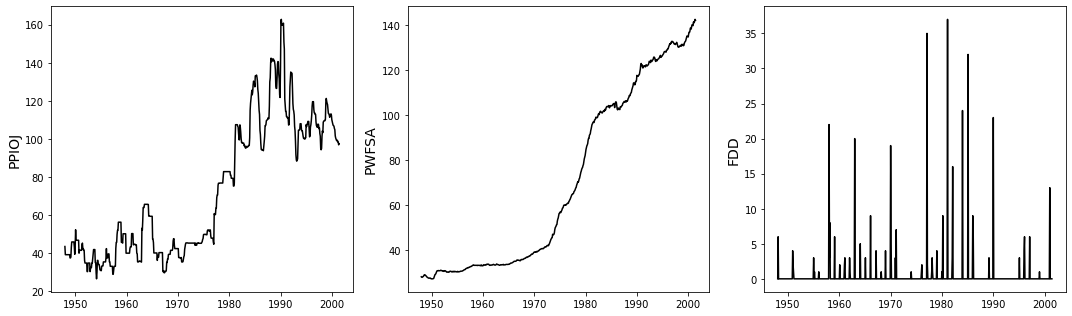

In [58]:
#color_list = ['k', 'r', 'g']
fig, ax_arr = plt.subplots(ncols=3, figsize=[15, 4.5])
for i, col in enumerate(oj_data.columns):
    ax = ax_arr.flat[i]
    ax.plot(oj_data.loc[:, col], color='k')
    ax.set_ylabel(col, fontsize=14)
fig.tight_layout()

Try model it: split the data first

In [59]:
N_train = int(0.9 * oj_data.shape[0])
N_test = oj_data.shape[0] - N_train
oj_train = oj_data.iloc[:N_train].copy(deep=True)

In [60]:
var = sm.tsa.VAR(oj_train).fit(maxlags=2)

/Users/zhiyzuo/.virtualenvs/py3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [61]:
var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Mar, 2022
Time:                     18:57:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.86772
Nobs:                     575.000    HQIC:                   2.77071
Log likelihood:          -3205.42    FPE:                    15.0096
AIC:                      2.70869    Det(Omega_mle):         14.4745
--------------------------------------------------------------------
Results for equation PPIOJ
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.440712         0.288350            1.528           0.126
L1.PPIOJ         1.243672         0.042364           29.357           0.000
L1.PWFSA         0.588116         0.335537            1.753           0.080
L1.F

Now we can forecast:

In [62]:
oj_data.iloc[N_train:]

,PPIOJ,PWFSA,FDD
Month,,,
1996-02-01,112.5,129.4,6
1996-03-01,117.2,130.1,0
1996-04-01,119.5,130.6,0
1996-05-01,119.5,131.1,0
1996-06-01,119.5,131.7,0
...,...,...,...
2001-02-01,99.2,141.4,0
2001-03-01,98.3,141.0,0
2001-04-01,98.3,141.7,0


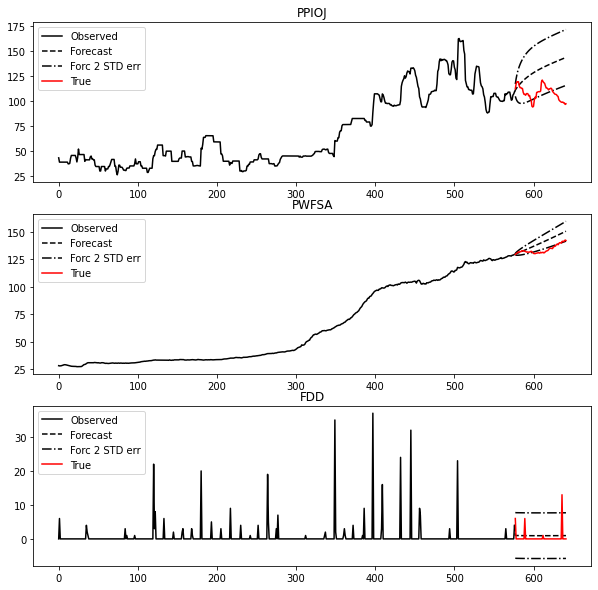

In [63]:
fig = var.plot_forecast(N_test)
for i, ax in enumerate(fig.axes):
    ## visualize the true value
    ax.plot(np.arange(N_train, oj_data.shape[0]),
            oj_data.iloc[N_train:][oj_data.columns[i]].values,
            color='r', label='True')
    ## change the location of the legend
    ax.legend(loc=2)

---

# In-Class Exercise

Use the data `EGY_Exports.csv` (collected from [link](https://rdrr.io/cran/tsibbledata/man/global_economy.html)) for the following analysis:
1. Is this time series stationary?
    - Start with a graphical approach
    - Use the KPSS test to quantitatively verify your visual inspection.
1. Discuss the pattern of trend or seasonality using (partial) autocorrelation diagram.
1. Split the data in a 80%-20% fashion for training-testing and then:
    - Train an AR model. How do you decide the order?
    - Train an ARIMA model with constant trend. How do you specify this model?
    - Also use the exponential smoothing method. Which model do you want?
    - Compare the performance on both the training and testing set.

---

# References

- Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts.
- Shmueli, G., & Lichtendahl Jr, K. C. (2016). Practical time series forecasting with R: A hands-on guide. Axelrod schnall publishers.
- STAT 510: Applied Time Series Analytics. https://online.stat.psu.edu/stat510/